In [1]:
import numpy as np
import nltk
import word2vec
import transformers
import requests
import pandas as pd
import matplotlib.pyplot as plt


datasource_config_file = '../data/datasources.yaml'

# Exemplo Simples com Word2Vec

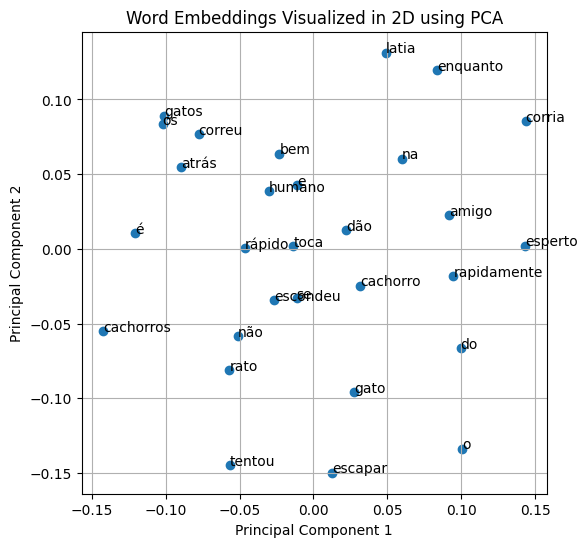

In [2]:
# Import necessary libraries
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Example sentences (corpus)
corpus = [
    ['gato', 'correu', 'rapidamente', 'atrás', 'do', 'rato'],
    ['o', 'gato', 'é', 'rápido', 'e', 'esperto'],
    ['o', 'rato', 'se', 'escondeu', 'na', 'toca'],
    ['o', 'cachorro', 'latia', 'enquanto', 'corria', 'atrás', 'do', 'gato'],
    ['os', 'gatos', 'e', 'os', 'cachorros', 'não', 'se', 'dão', 'bem'],
    ['o', 'cachorro', 'é', 'amigo', 'do', 'humano'],
    ['o', 'rato', 'tentou', 'escapar', 'do', 'gato']
]

# Train the Word2Vec model
model = Word2Vec(corpus, vector_size=10, window=2, min_count=1, workers=4)

# Get words in the model's vocabulary
words = list(model.wv.index_to_key)

# Get the word embeddings
word_embeddings = [model.wv[word] for word in words]

# Use PCA to reduce the dimensions to 2D for visualization
pca = PCA(n_components=2)
result = pca.fit_transform(word_embeddings)

# Plot the embeddings in 2D
plt.figure(figsize=(6, 6))
plt.scatter(result[:, 0], result[:, 1])

# Annotate each point with the corresponding word
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Corpus Machado de Assis

In [3]:
filepath = '../data/machado/obras_machado_de_assis.csv'

data = pd.read_csv(filepath, index_col=None)
data.head(2)

,arquivo,caminho completo,categoria,autor,paginas,titulo,edicao,publicacao,publicacao ano,publicacao editora,publicacao cidade,edicao ano,edicao editora,edicao cidade,edicao titulo,edicao volume,texto
0,revelacoes.pdf,./pdf/crítica/revelacoes.pdf,crítica,Machado de Assis,5,"Revelações. Poesias de A. E. Zaluar, Garnier e...",Texto-Fonte: Crítica Literária de Machado de A...,Publicado originalmente no Diário do Rio de Ja...,1863,Diário do Rio de Janeiro,Rio de Janeiro,1938,W. M. Jackson,Rio de Janeiro,Crítica Literária de Machado de Assis,NaN,"Revelações. Poesias de A. E. Zaluar, Garnier e..."
1,magalhaes.pdf,./pdf/crítica/magalhaes.pdf,crítica,Machado de Assis,4,Magalhães de Azeredo: Horas sagradas; Mário de...,Texto-Fonte: Obra Completa de Machado de Assis...,"Publicado na Gazeta de Notícias, 07/12/1902.",1902,Gazeta de Notícias,Rio de Janeiro,1994,Nova Aguilar,Rio de Janeiro,Obra Completa de Machado de Assis,III,Magalhães de Azeredo: Horas sagradas; Mário de...


## Quantidade de Obras por Categoria

<Axes: title={'center': 'Distribuição de Obras por Categoria'}, xlabel='Total Obras', ylabel='categoria'>

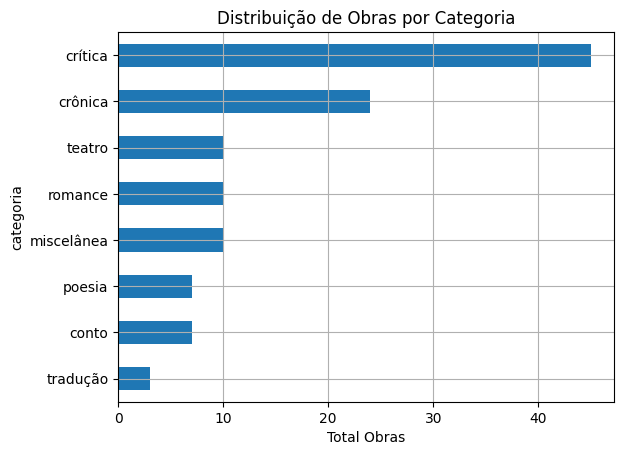

In [4]:
(data.groupby('categoria')
    .arquivo.nunique()
    .sort_values()
    .plot.barh(
        xlabel='Total Obras',
        grid=1,
        title='Distribuição de Obras por Categoria'
    )
)

## Pré-processamento do Corpus para montar o Vocabulário

In [5]:
category_name = 'romance'

# SELECAO DE OBRAS DA CATEGORIA
corpus = data[data.categoria == category_name].texto.tolist()
obras = data[data.categoria == category_name].titulo.tolist()
print('Corpus com', len(corpus), 'obras')

# PROCESSO SEPARACAO DE PALAVRAS
# words = nltk.tokenize.word_tokenize(obras[1])
# words = [nltk.tokenize.word_tokenize(o) for o in corpus] # por obra
# words = [nltk.tokenize.wordpunct_tokenize(o) for o in corpus] # por obra
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
corpus = [tokenizer.tokenize(o) for o in corpus] # por obra

# DOWNLOAD DOS ARQUIVOS COM STOPWORDS
nltk.download('stopwords')
from nltk.corpus import stopwords
pt_stopwords = stopwords.words('portuguese')
print('Total de stopwords', len(pt_stopwords))
corpus = [[w for w in o if w not in pt_stopwords] for o in corpus]
corpus[0][:20]

Corpus com 10 obras


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ciodaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total de stopwords 207


['Memórias',
 'Póstumas',
 'Brás',
 'Cubas',
 'Ao',
 'verme',
 'primeiro',
 'roeu',
 'frias',
 'carnes',
 'cadáver',
 'dedico',
 'saudosa',
 'lembrança',
 'Memórias',
 'Póstumas',
 'Prólogo',
 'terceira',
 'edição',
 'A']

## Word2Vec

In [6]:
model = gensim.models.Word2Vec(
    sentences=corpus,
    vector_size=100,
    alpha=0.025,
    window=25,
    min_count=10,
    seed=1,
    workers=3,
    sg=0,
)

# Train the Word2Vec model
# model = Word2Vec(corpus, vector_size=20, window=10, min_count=5, workers=4)
# Get words in the model's vocabulary
words = list(model.wv.index_to_key)
# Get the word embeddings
word_embeddings = [model.wv[word] for word in words]
# Use PCA to reduce the dimensions to 2D for visualization
pca = PCA(n_components=2)
result = pca.fit_transform(word_embeddings)

In [7]:
def strip_score(result):
    return [w for w, s in result]
# Lista as palavras mais próximas
def closest_words(word, model, num=5):
    word_score_pair = model.wv.most_similar(word, topn=num)
    return strip_score(word_score_pair)

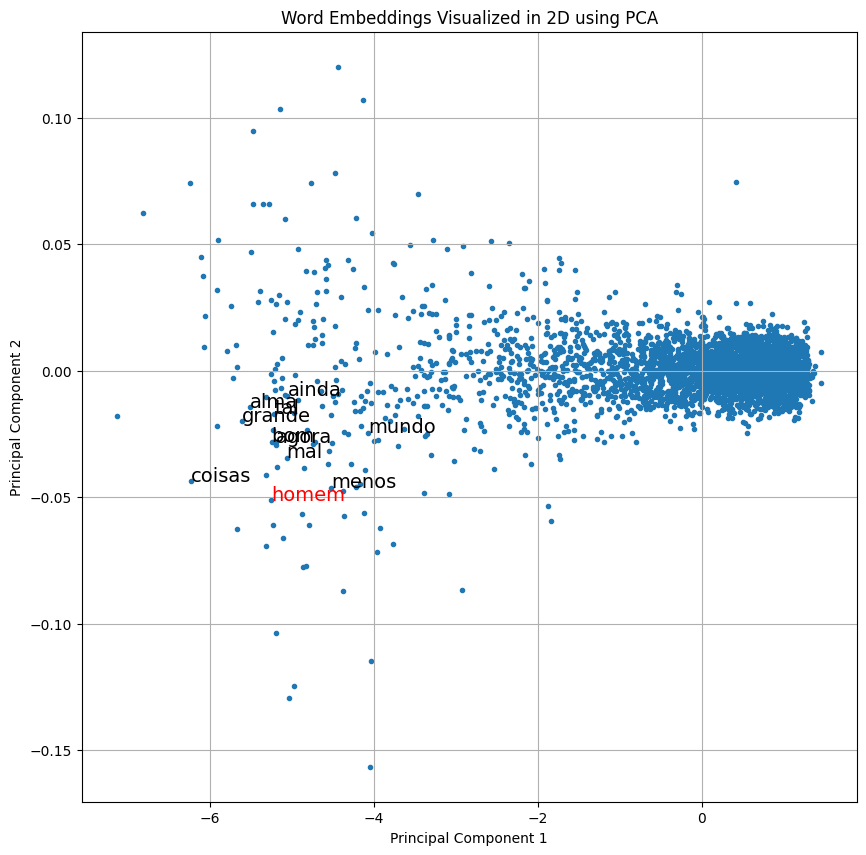

In [8]:
keyword = 'homem' #, 'Cubas', 'Brás', 'Capitu','Bentinho']


# Plot the embeddings in 2D
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1], marker='.')
# Annotate each point with the corresponding word
annotate_words = closest_words(keyword, model, num=10)
for word in annotate_words:    
    xpos = pca.transform([model.wv[word]])
    plt.annotate(word, xy=xpos[0], size=14, c='k')
xpos = pca.transform([model.wv[keyword]])
plt.annotate(keyword, xy=xpos[0], c='red', size=14)
# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Corpus Brasileiro

In [9]:
import glob

filepaths = glob.glob('../data/Brazilian_Portugese_Corpus/*.txt')
corpus = [' '.join(open(f, encoding='latin-1').readlines()) for f in filepaths]

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
corpus = [tokenizer.tokenize(o) for o in corpus] # por obra

# DOWNLOAD DOS ARQUIVOS COM STOPWORDS
nltk.download('stopwords')
from nltk.corpus import stopwords
pt_stopwords = stopwords.words('portuguese')
print('Total de stopwords', len(pt_stopwords))
corpus = [[w for w in o if w not in pt_stopwords] for o in corpus]
# UNIDECODE
from unidecode import unidecode
corpus = [unidecode(' '.join(o).lower()) for o in corpus]
corpus = [tokenizer.tokenize(o) for o in corpus] # por obra

len(corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ciodaro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total de stopwords 207


81

In [265]:
%%time

model = gensim.models.Word2Vec(
    sentences=corpus,
    vector_size=20,
    # alpha=0.025,
    window=10,
    min_count=10,
    seed=1,
    workers=8,
    sg=0,
    epochs = 100
)

# Train the Word2Vec model
# model = Word2Vec(corpus, vector_size=20, window=10, min_count=5, workers=4)
# Get words in the model's vocabulary
words = list(model.wv.index_to_key)
# Get the word embeddings
word_embeddings = [model.wv[word] for word in words]
# Use PCA to reduce the dimensions to 2D for visualization
pca = PCA(n_components=2)
result = pca.fit_transform(word_embeddings)

CPU times: user 2min 41s, sys: 372 ms, total: 2min 41s
Wall time: 24.3 s


In [10]:
len(model.wv.key_to_index)

4453

In [11]:
# model.wv.key_to_index
model.wv.index_to_key

['Não',
 'A',
 'disse',
 'O',
 'olhos',
 'casa',
 'ainda',
 'tempo',
 'outra',
 'nada',
 'tudo',
 'coisa',
 'outro',
 'vez',
 'lo',
 'D',
 'tão',
 'dia',
 'pouco',
 'Mas',
 'la',
 'moça',
 'porque',
 'E',
 'dois',
 'CAPÍTULO',
 'ia',
 'podia',
 'Rubião',
 'alguma',
 'dizer',
 'mãe',
 'menos',
 'Era',
 'coração',
 'homem',
 'alguns',
 'agora',
 'assim',
 'bem',
 'logo',
 'vida',
 'si',
 'duas',
 'lá',
 'Jorge',
 'ver',
 'mim',
 'pai',
 'mesma',
 'Que',
 'ir',
 'Estácio',
 'palavras',
 'noite',
 'mão',
 'mal',
 'melhor',
 'então',
 'Helena',
 'antes',
 'pode',
 'todos',
 'Félix',
 'anos',
 'dias',
 'amor',
 'fez',
 'ter',
 'algum',
 'verdade',
 'outros',
 'havia',
 'cabeça',
 'grande',
 'deu',
 'carta',
 'todas',
 'Luís',
 'ali',
 'aqui',
 'coisas',
 'Quando',
 'Se',
 'marido',
 'mãos',
 'alma',
 'sei',
 'dar',
 'primeira',
 'onde',
 'vezes',
 'senhor',
 'perguntou',
 'filha',
 'pé',
 'todo',
 'idéia',
 'mulher',
 'Eu',
 'senhora',
 'fazer',
 'fim',
 'viúva',
 'três',
 'porta',
 'respond

In [12]:
model.wv['amigo']

array([-0.31613937,  0.48007444,  0.33594194,  0.42299825,  0.33822685,
       -1.426859  ,  0.21790339,  1.174566  ,  0.00280887, -0.13287307,
       -0.5323006 , -1.1398314 , -0.63295627,  0.20941372,  0.23561938,
       -0.47849962,  0.2092802 , -0.8522232 ,  0.18256372, -1.7301716 ,
        0.85189474,  0.35989434,  0.3177775 , -0.48931333,  0.08369251,
        0.3584695 , -0.63437635, -0.7016366 , -0.3813459 , -0.36498865,
        0.37651822,  0.7491758 , -0.43190175, -0.6098806 ,  0.02695964,
        0.7226856 ,  0.03979098, -0.9838222 ,  0.00243398, -1.1594222 ,
       -0.17826466, -0.922996  , -0.37704885,  0.5115497 ,  0.39969584,
       -0.31402397,  0.01781507, -0.11853199,  0.05944522,  0.15620776,
        0.24238257, -0.6834866 , -0.2759843 , -0.10565933, -0.37014943,
        0.64828223,  0.36551878, -0.01661972, -0.6038063 ,  0.11306377,
        0.14146288,  0.72972804, -0.3175378 , -0.0635859 , -0.49220112,
        0.42568734, -0.5509435 ,  0.09422623, -0.88089967,  0.64

In [13]:
model.wv.most_similar(positive=['vinho'], topn=10)

[('Vitorino', 0.9940602779388428),
 ('Grande', 0.9940343499183655),
 ('terraço', 0.9939960837364197),
 ('deve', 0.9939834475517273),
 ('folha', 0.9939822554588318),
 ('beijou', 0.9939725995063782),
 ('feliz', 0.9939375519752502),
 ('vejo', 0.9939349293708801),
 ('constante', 0.9939262270927429),
 ('noiva', 0.9939180016517639)]

In [14]:
model.wv.most_similar(positive=['amigo'], topn=10)

[('alma', 0.9998481273651123),
 ('grande', 0.9998331665992737),
 ('ainda', 0.9998184442520142),
 ('bom', 0.999817967414856),
 ('Rubião', 0.9998177886009216),
 ('deste', 0.9998158812522888),
 ('aqui', 0.9998146295547485),
 ('homens', 0.9998143315315247),
 ('Se', 0.9998123049736023),
 ('outro', 0.9998112320899963)]

In [15]:
model.wv.most_similar(positive=['noivo', 'mulher'], negative = ['homem'] ,topn=10)

[('Olhe', 0.9978179931640625),
 ('outra', 0.9977768659591675),
 ('própria', 0.9977538585662842),
 ('esquerda', 0.9977348446846008),
 ('modo', 0.9977200031280518),
 ('ouvia', 0.9977114796638489),
 ('difícil', 0.9977093935012817),
 ('força', 0.9977076649665833),
 ('Um', 0.9977054595947266),
 ('nele', 0.9977006316184998)]

In [16]:
model.wv.most_similar(positive=['brasil'] ,topn=10)

KeyError: "Key 'brasil' not present in vocabulary"

In [ ]:
model.wv.similarity('capitu','bentinho')

In [17]:
model.wv.most_similar(positive=['pai', 'mae'], negative=['filho'], topn=10)

KeyError: "Key 'mae' not present in vocabulary"

# Plot dos Embeddings e Determinardos Termos

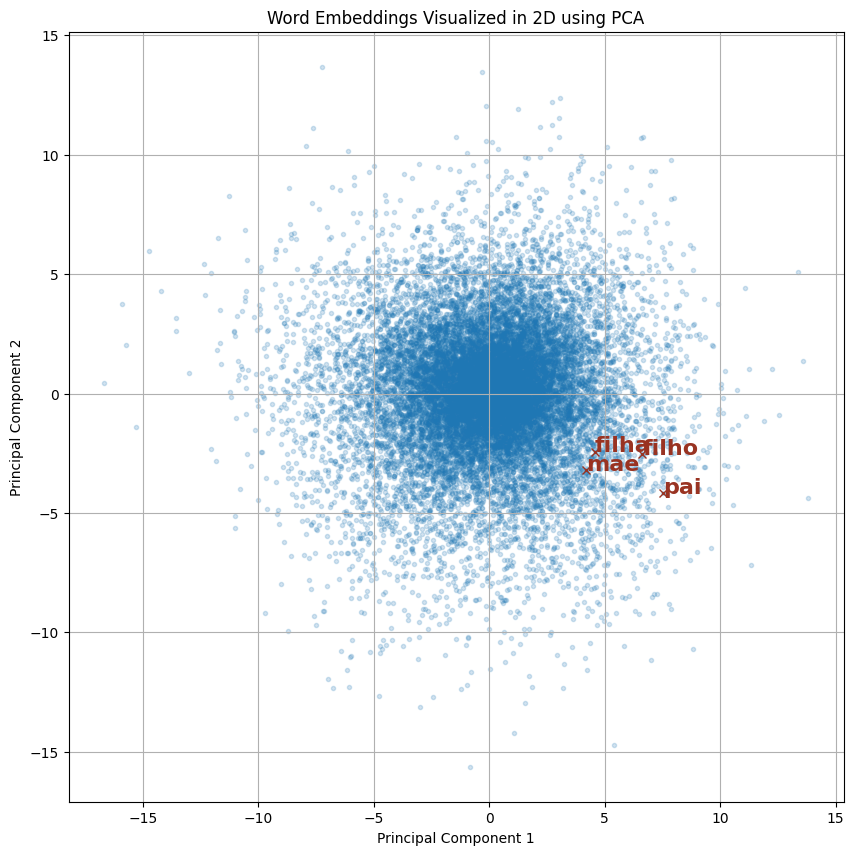

In [322]:
annotate_words = ['pai', 'mae','filho', 'filha'] #, 'Cubas', 'Brás', 'Capitu','Bentinho']

# Plot the embeddings in 2D
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1], marker='.', alpha=0.2)
# Annotate each point with the corresponding word
for word in annotate_words:    
    xpos = pca.transform([model.wv[word]])
    plt.annotate(word, xy=xpos[0], size=16, c='#993322', weight='bold')
    plt.plot(xpos[0][0], xpos[0][1], 'x', c='#993322')
# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Plot da Keyword e Termos Similares

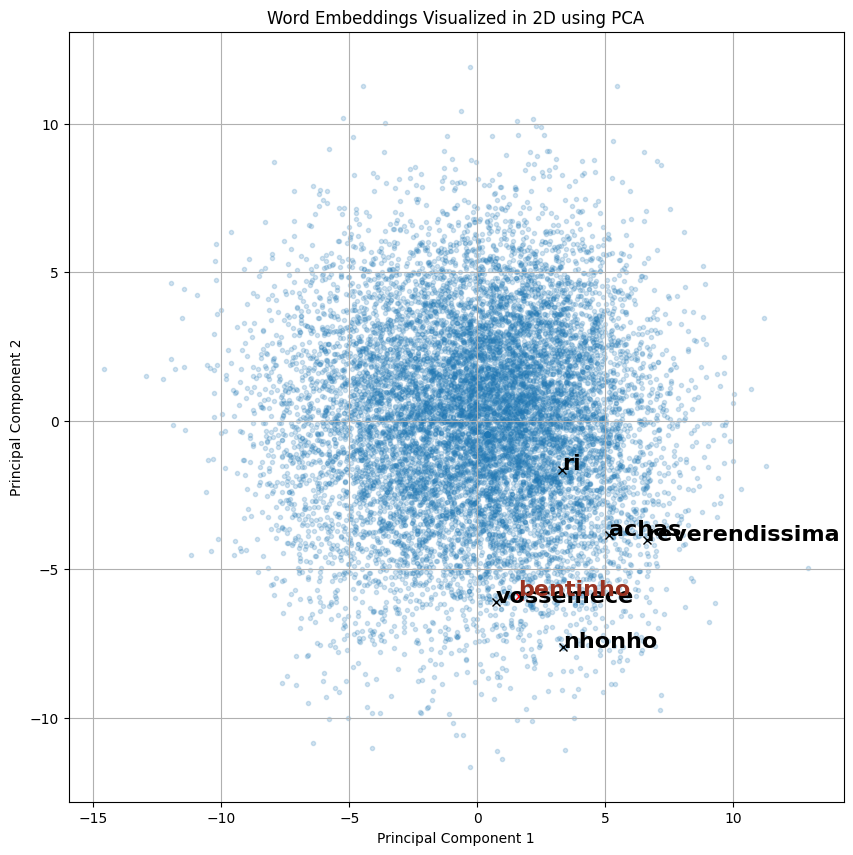

In [168]:
keyword = 'bentinho' #, 'Cubas', 'Brás', 'Capitu','Bentinho']

# Plot the embeddings in 2D
plt.figure(figsize=(10, 10))
plt.scatter(result[:, 0], result[:, 1], marker='.', alpha=0.2)
# Annotate each point with the corresponding word
annotate_words = closest_words(keyword, model, num=5)
for word in annotate_words:    
    xpos = pca.transform([model.wv[word]])
    plt.annotate(word, xy=xpos[0], size=16, c='k', weight='bold')
    plt.plot(xpos[0][0], xpos[0][1], 'kx')
xpos = pca.transform([model.wv[keyword]])
plt.annotate(keyword, xy=xpos[0], size=16, c='#993322', weight='bold')
plt.plot(xpos[0][0], xpos[0][1], 'rx')
# Show the plot
plt.title('Word Embeddings Visualized in 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [1]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")


[==================================================] 100.0% 66.0/66.0MB downloaded


# Embeddings

In [18]:
import glob
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

model_name = 'neuralmind/bert-base-portuguese-cased'
llm_model_dir = '../data/bertimbau/'


embedding_model = SentenceTransformer(model_name, cache_folder=llm_model_dir, device='cpu')

No sentence-transformers model found with name neuralmind/bert-base-portuguese-cased. Creating a new one with mean pooling.


In [19]:
filepaths = glob.glob('../data/Brazilian_Portugese_Corpus/*.txt')
corpus = [' '.join(open(f, encoding='latin-1').readlines()) for f in filepaths]
names =  [f.replace('../data/Brazilian_Portugese_Corpus/','').replace('.txt','') for f in filepaths]
meta = pd.read_csv('../data/guideToDocuments.csv')
authors = [meta[meta.Work.str.replace(",", '').str.replace("'",'') == f"{x}.txt"].Author.tolist()[0] for x in names]

In [20]:
%%time

embeddings = embedding_model.encode(corpus, show_progress_bar=True)


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 2min 20s, sys: 14.1 s, total: 2min 34s
Wall time: 38.7 s


In [21]:
len(embeddings[0])


768

In [29]:
from umap import UMAP

umap_model = UMAP(
    n_neighbors=5, 
    n_components=2, 
    min_dist=0.0,
    metric='cosine',
    low_memory=True,
    random_state=42
)
Xumap = umap_model.fit_transform(embeddings)

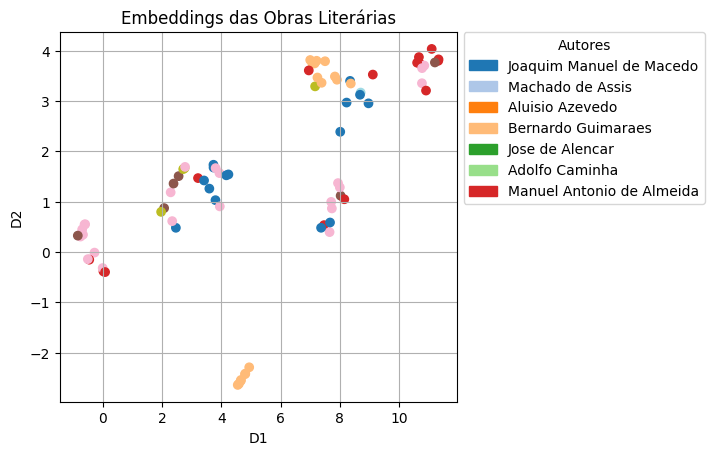

In [135]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches

levels, categories = pd.factorize(authors)
colors = [plt.cm.tab20(i) for i in levels] # using the "tab20" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab20(i), label=c) for i, c in enumerate(categories)]
plt.scatter(Xumap[:,0], Xumap[:,1], c=pd.factorize(authors)[0], cmap='tab20')
plt.gca().set(xlabel='D1', ylabel='D2', title='Embeddings das Obras Literárias')

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.gca().legend(handles=handles,  title='Autores', loc='center left', bbox_to_anchor=(1, 0.767))
plt.grid(1)
    

    

## Exemplos de Embeddings 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

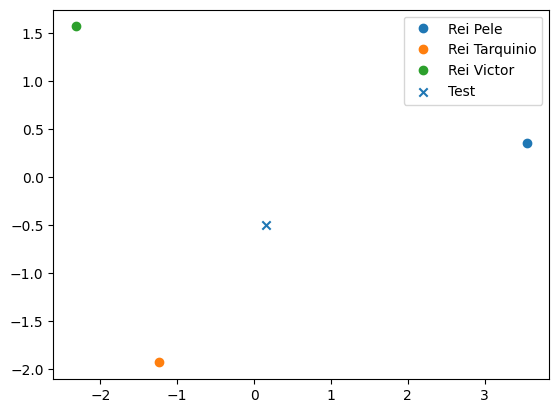

In [25]:
example_corpus = [
    'o rei do futebol é o pelé, que nunca jogou para o roma, da italia',
    'o ultimo rei de roma foi tarquinio, o tirano, antes da unificacao da italia',
    'a italia moderna foi unificada com lideranca do rei Victor Manuel',
]
example_label=['Rei Pele', 'Rei Tarquinio', 'Rei Victor']
embeddings = embedding_model.encode(example_corpus, show_progress_bar=True)

pca_model = PCA(n_components=2).fit(embeddings)
Xpca = pca_model.transform(embeddings)
# plt.scatter(Xpca[:,0], Xpca[:,1])
for i, lab in enumerate(example_label):
    plt.plot(Xpca[i,0], Xpca[i,1], 'o', label=example_label[i])



# frase similar de teste
test_example = ['o rei mais tirano que roma ja teve']
embeddings = embedding_model.encode(test_example , show_progress_bar=True)
Xpca = pca_model.transform(embeddings)
plt.scatter(Xpca[:,0], Xpca[:,1], marker='x', label='Test')

plt.legend(loc='best')

    

# Enriquecimento de Dados

## NER 

In [ ]:
# <descricao>
#       </descricao>
#     </valorRef>
#     <valorRef>
#       <cod>39</cod>
#       <sigla>
#       </sigla>
#       <nome>Esporte e Lazer</nome>
#       <descricao>
#       </descricao>
#     </valorRef>
#     <valorRef>
#       <cod>40</cod>
#       <sigla>
#       </sigla>
#       <nome>Economia</nome>
#       <descricao>
#       </descricao>
#     </valorRef>
#     <valorRef>
#       <cod>41</cod>

In [37]:
import requests

camara_base_url = 'https://dadosabertos.camara.leg.br/api/v2/'

resp = requests.get(
    url = f"{camara_base_url}/proposicoes",
    params={
        'dataFim': '2024-10-10',
        'dataInicio': '2024-10-01',
        'codTema': [40]
    },
    headers = {
        "Accept": "application/json"
    }
)


In [52]:
import pandas as pd


X = resp.json()
# X = pd.DataFrame().from_dict(resp.json())
# X['dados']
# X['links']

[{'id': 2053456,
  'uri': 'https://dadosabertos.camara.leg.br/api/v2/proposicoes/2053456',
  'siglaTipo': 'PL',
  'codTipo': 139,
  'numero': 3567,
  'ano': 2015,
  'ementa': 'Institui a Política Nacional para o Manejo Sustentável e Plantio das Palmeiras do Açaí, da Juçara e das demais espécies de interesse econômico integrantes da família das palmáceas.'},
 {'id': 2147717,
  'uri': 'https://dadosabertos.camara.leg.br/api/v2/proposicoes/2147717',
  'siglaTipo': 'PL',
  'codTipo': 139,
  'numero': 8274,
  'ano': 2017,
  'ementa': 'Altera a Lei nº 7.102, de 20 de junho de 1983, para obrigar os estabelecimentos financeiros a possuir circuito fechado de televisão que atenda aos requisitos mínimos estabelecidos pelo Departamento de Polícia Federal, devendo as imagens ser armazenadas por, no mínimo, sessenta dias'},
 {'id': 2158309,
  'uri': 'https://dadosabertos.camara.leg.br/api/v2/proposicoes/2158309',
  'siglaTipo': 'PL',
  'codTipo': 139,
  'numero': 8929,
  'ano': 2017,
  'ementa': 'Al